In [206]:
%matplotlib inline
import numpy as np
import h5py
import pymc3 as pm
import pymc as pm2
import itertools
import matplotlib.pylab as plt
import theano.tensor as t
from theano.tensor.nlinalg import matrix_inverse as inv

In [2]:
# Loading the split
participants_train = {}
participants_test = {}
filename = '../HAR/preprocessed.hdf5'
with h5py.File(filename,'r') as hf:
    x_train = np.array(hf['x_train'])
    y_train = np.array(hf['y_train'])
    x_test = np.array(hf['x_test'])
    y_test = np.array(hf['y_test'])

In [3]:
transition = np.zeros((6,6))
for i in range(1,len(y_train)):
    transition[y_train[i-1]-1, y_train[i]-1] += 1
row_sums = transition.sum(axis=1)
transition = transition / row_sums[:, np.newaxis]

In [4]:
cols = [0,1,2,40,41,42]
reduced_train = x_train[:,cols]
reduced_train = (reduced_train - np.mean(reduced_train, axis=0)) / np.std(reduced_train, axis=0)

In [5]:
reduced_train_1 = reduced_train[y_train[y_train == 1],:]
reduced_train_2 = reduced_train[y_train[y_train == 2],:]
reduced_train_3 = reduced_train[y_train[y_train == 3],:]
reduced_train_4 = reduced_train[y_train[y_train == 4],:]
reduced_train_5 = reduced_train[y_train[y_train == 5],:]
reduced_train_6 = reduced_train[y_train[y_train == 6],:]

In [198]:
n_var = 6
n_elem = int(n_var * (n_var - 1) / 2)

In [246]:
tri_index_1 = np.zeros([n_var, n_var], dtype=int)
tri_index_1[np.triu_indices(n_var, k=1)] = np.arange(n_elem)
tri_index_1[np.triu_indices(n_var, k=1)[::-1]] = np.arange(n_elem)

with pm.Model() as model1:
    
    mu_1 = pm.Normal('mu_1', mu=0, tau=1 ** -2, shape=n_var)

    # We can specify separate priors for sigma and the correlation matrix:
    sigma_1 = pm.Uniform('sigma_1', shape=n_var)
    corr_triangle_1 = pm.LKJCorr('corr_1', n=1, p=n_var, testval=np.random.randn(n_elem) * 0.5)
    corr_matrix_1 = corr_triangle_1[tri_index_1]
    corr_matrix_1 = t.fill_diagonal(corr_matrix_1, 1)

    cov_matrix_1 = t.diag(sigma_1).dot(corr_matrix_1.dot(t.diag(sigma_1)))

    like_1 = pm.MvNormal('likelihood_1', mu=mu_1, tau=inv(cov_matrix_1), observed=reduced_train_1)
    
with model1:
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    tr1 = pm.sample(5000, step=step, start=start)

Applied interval-transform to sigma_1 and added transformed sigma_1_interval to model.


LinAlgError: Singular matrix
Apply node that caused the error: MatrixInverse(Dot22.0)
Toposort index: 22
Inputs types: [TensorType(float64, matrix)]
Inputs shapes: [(6, 6)]
Inputs strides: [(48, 8)]
Inputs values: ['not shown']
Outputs clients: [[Det(MatrixInverse.0), Dot22(Elemwise{sub,no_inplace}.0, MatrixInverse.0)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/Users/virgileaudi/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 260, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/virgileaudi/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 212, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/virgileaudi/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 370, in execute_request
    user_expressions, allow_stdin)
  File "/Users/virgileaudi/anaconda/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 175, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/virgileaudi/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2902, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/virgileaudi/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 3006, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/virgileaudi/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 3066, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-246-c131e9972d4c>", line 17, in <module>
    like_1 = pm.MvNormal('likelihood_1', mu=mu_1, tau=inv(cov_matrix_1), observed=reduced_train_1)

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [194]:
corr_matrix_1_ = np.array(tr1['corr_1'][-100:].mean(axis=0)[tri_index_1])
np.fill_diagonal(corr_matrix_1_, 1)
sigma_1_ = np.array(tr1['sigma_1'][-100:].mean(axis=0))
cov_matrix_1_ = np.diag(sigma_1_).dot(corr_matrix_1_.dot(np.diag(sigma_1_)))

mu_1_ = tr1['mu_1'][-100:].mean(axis = 0)

In [197]:
tri_index_2 = np.zeros([n_var, n_var], dtype=int)
tri_index_2[np.triu_indices(n_var, k=1)] = np.arange(n_elem)
tri_index_2[np.triu_indices(n_var, k=1)[::-1]] = np.arange(n_elem)

with pm.Model() as model2:
    
    mu_2 = pm.Normal('mu_2', mu=0, tau=1 ** -2, shape=n_var)

    # We can specify separate priors for sigma and the correlation matrix:
    sigma_2 = pm.Uniform('sigma_2', shape=n_var)
    corr_triangle_2 = pm.LKJCorr('corr_2', n=1, p=n_var)
    corr_matrix_2 = corr_triangle_2[tri_index_2]
    corr_matrix_2 = t.fill_diagonal(corr_matrix_2, 1)

    cov_matrix_2 = t.diag(sigma_2).dot(corr_matrix_2.dot(t.diag(sigma_2)))

    like_2 = pm.MvNormal('likelihood_2', mu=mu_2, tau=inv(cov_matrix_2), observed=reduced_train_2)
    
with model2:
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    tr2 = pm.sample(5000, step=step, start=start)

corr_matrix_2_ = np.array(tr2['corr_2'][-100:].mean(axis=0)[tri_index_2])
np.fill_diagonal(corr_matrix_2_, 1)
sigma_2_ = np.array(tr2['sigma_2'][-100:].mean(axis=0))
cov_matrix_2_ = np.diag(sigma_2_).dot(corr_matrix_2_.dot(np.diag(sigma_2_)))

mu_2_ = tr2['mu_2'][-100:].mean(axis = 0)

Applied interval-transform to sigma_2 and added transformed sigma_2_interval to model.


LinAlgError: Singular matrix
Apply node that caused the error: MatrixInverse(Dot22.0)
Toposort index: 22
Inputs types: [TensorType(float64, matrix)]
Inputs shapes: [(6, 6)]
Inputs strides: [(48, 8)]
Inputs values: ['not shown']
Outputs clients: [[Det(MatrixInverse.0), Dot22(Elemwise{sub,no_inplace}.0, MatrixInverse.0)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/Users/virgileaudi/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 260, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/virgileaudi/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 212, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/virgileaudi/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 370, in execute_request
    user_expressions, allow_stdin)
  File "/Users/virgileaudi/anaconda/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 175, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/virgileaudi/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2902, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/virgileaudi/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 3006, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/virgileaudi/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 3066, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-197-a5ae882d81d9>", line 17, in <module>
    like_2 = pm.MvNormal('likelihood_2', mu=mu_2, tau=inv(cov_matrix_2), observed=reduced_train_2)

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [188]:
tri_index_3 = np.zeros([n_var, n_var], dtype=int)
tri_index_3[np.triu_indices(n_var, k=1)] = np.arange(n_elem)
tri_index_3[np.triu_indices(n_var, k=1)[::-1]] = np.arange(n_elem)

with pm.Model() as model3:
    
    mu_3 = pm.Normal('mu_3', mu=0, tau=1 ** -2, shape=n_var)

    # We can specify separate priors for sigma and the correlation matrix:
    sigma_3 = pm.Uniform('sigma_3', shape=n_var)
    corr_triangle_3 = pm.LKJCorr('corr_3', n=1, p=n_var)
    corr_matrix_3 = corr_triangle_3[tri_index_3]
    corr_matrix_3 = t.fill_diagonal(corr_matrix_3, 1)

    cov_matrix_3 = t.diag(sigma_3).dot(corr_matrix_3.dot(t.diag(sigma_3)))

    like_3 = pm.MvNormal('likelihood_3', mu=mu_3, tau=cov_matrix_3, observed=reduced_train_3)
    
with model3:
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    tr3 = pm.sample(5000, step=step, start=start)

corr_matrix_3_ = np.array(tr3['corr_3'][-100:].mean(axis=0)[tri_index_3])
np.fill_diagonal(corr_matrix_3_, 1)
sigma_3_ = np.array(tr3['sigma_3'][-100:].mean(axis=0))
cov_matrix_3_ = np.diag(sigma_3_).dot(corr_matrix_3_.dot(np.diag(sigma_3_)))

mu_3_ = tr3['mu_3'][-100:].mean(axis = 0)

Applied interval-transform to sigma_3 and added transformed sigma_3_interval to model.
 [-----------------100%-----------------] 5000 of 5000 complete in 23.8 sec

In [189]:
tri_index_4 = np.zeros([n_var, n_var], dtype=int)
tri_index_4[np.triu_indices(n_var, k=1)] = np.arange(n_elem)
tri_index_4[np.triu_indices(n_var, k=1)[::-1]] = np.arange(n_elem)

with pm.Model() as model4:
    
    mu_4 = pm.Normal('mu_4', mu=0, tau=1 ** -2, shape=n_var)

    # We can specify separate priors for sigma and the correlation matrix:
    sigma_4 = pm.Uniform('sigma_4', shape=n_var)
    corr_triangle_4 = pm.LKJCorr('corr_4', n=1, p=n_var)
    corr_matrix_4 = corr_triangle_4[tri_index_4]
    corr_matrix_4 = t.fill_diagonal(corr_matrix_4, 1)

    cov_matrix_4 = t.diag(sigma_4).dot(corr_matrix_4.dot(t.diag(sigma_4)))

    like_4 = pm.MvNormal('likelihood_4', mu=mu_4, tau=cov_matrix_4, observed=reduced_train_4)
    
with model4:
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    tr4 = pm.sample(5000, step=step, start=start)

corr_matrix_4_ = np.array(tr4['corr_4'][-100:].mean(axis=0)[tri_index_4])
np.fill_diagonal(corr_matrix_4_, 1)
sigma_4_ = np.array(tr4['sigma_4'][-100:].mean(axis=0))
cov_matrix_4_ = np.diag(sigma_4_).dot(corr_matrix_4_.dot(np.diag(sigma_4_)))

mu_4_ = tr4['mu_4'][-100:].mean(axis = 0)

Applied interval-transform to sigma_4 and added transformed sigma_4_interval to model.
 [-----------------100%-----------------] 5000 of 5000 complete in 25.8 sec

In [190]:
tri_index_5 = np.zeros([n_var, n_var], dtype=int)
tri_index_5[np.triu_indices(n_var, k=1)] = np.arange(n_elem)
tri_index_5[np.triu_indices(n_var, k=1)[::-1]] = np.arange(n_elem)

with pm.Model() as model5:
    
    mu_5 = pm.Normal('mu_5', mu=0, tau=1 ** -2, shape=n_var)

    # We can specify separate priors for sigma and the correlation matrix:
    sigma_5 = pm.Uniform('sigma_5', shape=n_var)
    corr_triangle_5 = pm.LKJCorr('corr_5', n=1, p=n_var)
    corr_matrix_5 = corr_triangle_5[tri_index_5]
    corr_matrix_5 = t.fill_diagonal(corr_matrix_5, 1)

    cov_matrix_5 = t.diag(sigma_5).dot(corr_matrix_5.dot(t.diag(sigma_5)))

    like_5 = pm.MvNormal('likelihood_5', mu=mu_5, tau=cov_matrix_5, observed=reduced_train_5)
    
with model5:
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    tr5 = pm.sample(5000, step=step, start=start)

corr_matrix_5_ = np.array(tr5['corr_5'][-100:].mean(axis=0)[tri_index_5])
np.fill_diagonal(corr_matrix_5_, 1)
sigma_5_ = np.array(tr5['sigma_5'][-100:].mean(axis=0))
cov_matrix_5_ = np.diag(sigma_5_).dot(corr_matrix_5_.dot(np.diag(sigma_5_)))

mu_5_ = tr5['mu_5'][-100:].mean(axis = 0)

Applied interval-transform to sigma_5 and added transformed sigma_5_interval to model.
 [-----------------100%-----------------] 5000 of 5000 complete in 29.0 sec

In [191]:
tri_index_6 = np.zeros([n_var, n_var], dtype=int)
tri_index_6[np.triu_indices(n_var, k=1)] = np.arange(n_elem)
tri_index_6[np.triu_indices(n_var, k=1)[::-1]] = np.arange(n_elem)

with pm.Model() as model6:
    
    mu_6 = pm.Normal('mu_6', mu=0, tau=1 ** -2, shape=n_var)

    # We can specify separate priors for sigma and the correlation matrix:
    sigma_6 = pm.Uniform('sigma_6', shape=n_var)
    corr_triangle_6 = pm.LKJCorr('corr_6', n=1, p=n_var)
    corr_matrix_6 = corr_triangle_6[tri_index_6]
    corr_matrix_6 = t.fill_diagonal(corr_matrix_6, 1)

    cov_matrix_6 = t.diag(sigma_6).dot(corr_matrix_6.dot(t.diag(sigma_6)))

    like_6 = pm.MvNormal('likelihood_6', mu=mu_6, tau=cov_matrix_6, observed=reduced_train_6)
    
with model6:
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    tr6 = pm.sample(5000, step=step, start=start)

corr_matrix_6_ = np.array(tr6['corr_6'][-100:].mean(axis=0)[tri_index_6])
np.fill_diagonal(corr_matrix_6_, 1)
sigma_6_ = np.array(tr6['sigma_6'][-100:].mean(axis=0))
cov_matrix_6_ = np.diag(sigma_6_).dot(corr_matrix_6_.dot(np.diag(sigma_6_)))

mu_6_ = tr6['mu_6'][-100:].mean(axis = 0)

Applied interval-transform to sigma_6 and added transformed sigma_6_interval to model.
 [-----------------100%-----------------] 5000 of 5000 complete in 47.0 sec

In [195]:
means = [mu_1_, mu_2_, mu_3_, mu_4_, mu_5_, mu_6_]
covs = [cov_matrix_1_, cov_matrix_2_, cov_matrix_3_, cov_matrix_4_, cov_matrix_5_, cov_matrix_6_]

with h5py.File('../HAR/means_covs.hdf5', "w") as f:
    for k,v in enumerate(means):
        f['mu_{}'.format(k+1)] = v
    for k,v in enumerate(covs):
        f['cov_{}'.format(k+1)] = v

### OLD:

In [207]:
mu_1 = pm2.MvNormal('mu_1', mu = np.zeros(6), tau = np.diag(np.ones(6)))
cov_1 = pm2.Wishart('cov_1', 7, np.eye(6))
like = pm2.MvNormalCov('l1', mu = mu_1, C = cov_1, observed = True, value = reduced_train_1)
model1 = pm2.Model([mu_1, cov_1, like])
mcmc1 = pm2.MCMC(model1)
mcmc1.sample(iter=10000, burn=2000)
mu1 = mcmc1.trace('mu_1')[:][-1]
cov1 = mcmc1.trace('cov_1')[:][-1]

 [-----------------100%-----------------] 10000 of 10000 complete in 27.7 sec

In [210]:
mcmc1.trace('cov_1')[:]

array([[[ 8.28253838, -0.0162907 , -5.05768915,  5.82878173,  0.4751894 ,
         -0.54094005],
        [-0.0162907 ,  2.78619643,  2.46791526,  0.16438314,  1.27375753,
         -0.79160727],
        [-5.05768915,  2.46791526,  8.31836331, -0.25199832,  1.33523928,
          0.75144647],
        [ 5.82878173,  0.16438314, -0.25199832,  8.42011064,  1.92041801,
          0.50437627],
        [ 0.4751894 ,  1.27375753,  1.33523928,  1.92041801,  2.81926942,
         -1.55109011],
        [-0.54094005, -0.79160727,  0.75144647,  0.50437627, -1.55109011,
          2.93739643]],

       [[ 8.28253838, -0.0162907 , -5.05768915,  5.82878173,  0.4751894 ,
         -0.54094005],
        [-0.0162907 ,  2.78619643,  2.46791526,  0.16438314,  1.27375753,
         -0.79160727],
        [-5.05768915,  2.46791526,  8.31836331, -0.25199832,  1.33523928,
          0.75144647],
        [ 5.82878173,  0.16438314, -0.25199832,  8.42011064,  1.92041801,
          0.50437627],
        [ 0.4751894 ,  1.273

ValueError: x and y can be no greater than 2-D

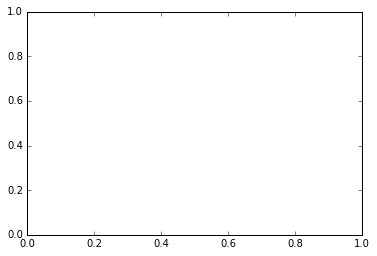

In [209]:
plt.plot(mcmc1.trace('cov_1')[:])

In [43]:
mu_2 = pm.MvNormal('mu_2', mu = np.zeros(6), tau = np.diag(np.ones(6)*100))
cov_2 = pm.Wishart('cov_2', len(reduced_train_2), np.eye(6))
like2 = pm.MvNormal('l2', mu_2, cov_2, observed = True, value = reduced_train_2)
model2 = pm.Model([mu_2, cov_2, like2])
mcmc2 = pm.MCMC(model2)
mcmc2.sample(iter=10000, burn=2000)
mu2 = mcmc2.trace('mu_2')[:][-1]
cov2 = mcmc2.trace('cov_2')[:][-1]

 [-----------------100%-----------------] 10000 of 10000 complete in 23.2 sec

In [54]:
mu_3 = pm.MvNormal('mu_3', mu = np.zeros(6), tau = np.diag(np.ones(6)*100))
cov_3 = pm.Wishart('cov_3', len(reduced_train_3), np.eye(6))
like3 = pm.MvNormal('l3', mu_3, cov_3, observed = True, value = reduced_train_3)
model3 = pm.Model([mu_3, cov_3, like3])
mcmc3 = pm.MCMC(model3)
mcmc3.sample(iter=10000, burn=2000)
mu3 = mcmc3.trace('mu_3')[:][-1]
cov3 = mcmc3.trace('cov_3')[:][-1]

 [-----------------100%-----------------] 10000 of 10000 complete in 20.3 sec

In [55]:
mu_4 = pm.MvNormal('mu_4', mu = np.zeros(6), tau = np.diag(np.ones(6)*100))
cov_4 = pm.Wishart('cov_4', len(reduced_train_4), np.eye(6))
like4 = pm.MvNormal('l4', mu_4, cov_4, observed = True, value = reduced_train_4)
model4 = pm.Model([mu_4, cov_4, like4])
mcmc4 = pm.MCMC(model4)
mcmc4.sample(iter=10000, burn=2000)
mu4 = mcmc4.trace('mu_4')[:][-1]
cov4 = mcmc4.trace('cov_4')[:][-1]

 [-----------------100%-----------------] 10000 of 10000 complete in 26.6 sec

In [56]:
mu_5 = pm.MvNormal('mu_5', mu = np.zeros(6), tau = np.diag(np.ones(6)*100))
cov_5 = pm.Wishart('cov_5', len(reduced_train_5), np.eye(6))
like5 = pm.MvNormal('l5', mu_5, cov_5, observed = True, value = reduced_train_5)
model5 = pm.Model([mu_5, cov_5, like5])
mcmc5 = pm.MCMC(model5)
mcmc5.sample(iter=10000, burn=2000)
mu5 = mcmc5.trace('mu_5')[:][-1]
cov5 = mcmc5.trace('cov_5')[:][-1]

 [-----------------100%-----------------] 10000 of 10000 complete in 30.2 sec

In [57]:
mu_6 = pm.MvNormal('mu_6', mu = np.zeros(6), tau = np.diag(np.ones(6)*100))
cov_6 = pm.Wishart('cov_6', len(reduced_train_6), np.eye(6))
like6 = pm.MvNormal('l6', mu_6, cov_6, observed = True, value = reduced_train_6)
model6 = pm.Model([mu_6, cov_6, like6])
mcmc6 = pm.MCMC(model6)
mcmc6.sample(iter=10000, burn=2000)
mu6 = mcmc6.trace('mu_6')[:][-1]
cov6 = mcmc6.trace('cov_6')[:][-1]

 [-----------------100%-----------------] 10000 of 10000 complete in 27.7 sec

In [227]:
p=6 
prior_mu=np.zeros(p)
prior_sdev=np.ones(p)
prior_corr_inv=np.eye(p)
prior_cov=np.diag(prior_sdev)*np.linalg.inv(prior_corr_inv)*np.diag(prior_sdev)
post_mu = pm2.Normal("mu",prior_mu,1,size=p)
post_sdev=pm2.Lognormal("sdev",prior_sdev,1,size=p)
post_corr_inv=pm2.Wishart("inv_corr",7,prior_corr_inv)
@pm2.deterministic 
def post_cov_matrix_inv(post_sdev=post_sdev,post_corr_inv=post_corr_inv): 
    post_sdev_inv=(post_sdev)**-1 
    return np.diag(post_sdev_inv)*post_corr_inv*np.diag(post_sdev_inv) 
obs = pm2.MvNormal( "observed returns", post_mu, post_cov_matrix_inv, observed = True, value = reduced_train_1 ) 
model = pm2.Model( [obs, post_mu, post_sdev ,post_corr_inv]) 
mcmc = pm2.MCMC(model) 
mcmc.sample( 5000, 1000) 

 [-----------------100%-----------------] 5000 of 5000 complete in 16.1 sec

In [228]:
mcmc.trace('inv_corr')[:]

array([[[  7.19865555,  -0.29739913,   3.79510106,  -3.80090251,
           1.80705751,  -2.07208991],
        [ -0.29739913,   5.86940035,  -0.38398385,  -0.25385092,
          -1.38430505,   1.38751712],
        [  3.79510106,  -0.38398385,   8.33632589,  -1.00368738,
           6.56711139,  -1.55099252],
        [ -3.80090251,  -0.25385092,  -1.00368738,   3.10967552,
           0.28264662,   1.04295289],
        [  1.80705751,  -1.38430505,   6.56711139,   0.28264662,
          10.3505527 ,  -1.56785656],
        [ -2.07208991,   1.38751712,  -1.55099252,   1.04295289,
          -1.56785656,   1.95225849]],

       [[  7.19865555,  -0.29739913,   3.79510106,  -3.80090251,
           1.80705751,  -2.07208991],
        [ -0.29739913,   5.86940035,  -0.38398385,  -0.25385092,
          -1.38430505,   1.38751712],
        [  3.79510106,  -0.38398385,   8.33632589,  -1.00368738,
           6.56711139,  -1.55099252],
        [ -3.80090251,  -0.25385092,  -1.00368738,   3.10967552,
      